# Machine Learning with Time Series

In this notebook, we continue with our time series discussion by talking about ML techniques for dealing with time series. Specifically, we focus on supervised learning with time series. Recall in supervised learning that you are given a dataset $D=\{(x_1,y_1),\cdots,(x_n,y_n)\}$ of input-output pairs. Assuming there is some function $y=f(x)$ generating the outputs as functions of inputs, the goal is to use $D$ to learn a function $\hat y=g(x)$ such that $\hat y \approx y$.

Time series are complicated by the fact that both inputs and outputs in the data may depend on time, i.e. $x=x(t)$ and $y=f(x(t),t)$. This makes it difficult to learn $f$ as a function of $x$, since $f$ now depends also on time. In practice, this means that learning $\hat y \approx f(x,t)$ for any value of time is infeasible. This is the problem of extrapolation, which includes trying to predict things that will happen in the future since your model won't have seen them yet. In practice what we often resort to is learning $\hat y$ only for short time spans, and constantly retraining the model periodically to get a new $\hat y$.

The example we'll work through here is _forecasting_, which involves using past points in a time series to predict future points in the time series. Since we have the time series, we can get a supervised learning problem by simply lagging the time series. The lagged values become the inputs, and the original series becomes the outputs. We'll be doing forecasting using the same CO2 dataset from last time. Since that time series is continuous, this means we're doing regression.

The new library we will use in this notebook is [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html), which is an up and coming library useful for extracting features from time series. Note this library is still very much in development, and so you may easily run into bugs and other weird quirks when using it. Nevertheless, the library makes the very time consuming tasks of manipulating time series and extracting features quite easy.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from tqdm import tqdm_notebook as tqdm

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series, make_forecasting_frame

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

np.random.seed(23)

In [111]:
def get_data():
    df = sm.datasets.co2.load_pandas().data
    df.index = pd.to_datetime(df.index)
    df = df.resample('M').mean().interpolate('linear')
    df.columns = ['x']
    return df

def get_scores(model,X_train,y_train,X_test,y_test):
    if model is None:
        yhat = X_train.x
        score = r2_score(y_train,yhat)
        print('Training R-squared: %f' % round(score,3))
        yhat = X_test.x
        score = r2_score(y_test,yhat)
        print('Test R-squared: %f' % round(score,3))
    else:
        yhat = model.predict(X_train)
        score = r2_score(y_train,yhat)
        print('Training R-squared: %f' % round(score,3))
        yhat = model.predict(X_test)
        score = r2_score(y_test,yhat)
        print('Test R-squared: %f' % round(score,3))
        if isinstance(model,RandomForestRegressor):
            score = model.oob_score_
            print('Out of Bag Score: %f' % round(score,3))

def time_series_split(X,y,test_size=0.2):
    split_index = round(len(y)*(1-test_size))-1
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

def get_lag_features(X,features=None,n_lags=1):
    if features is None:
        features = X.columns
    for feature in features:
        for i in range(1,n_lags+1):
            X[feature+'_lag_'+str(i)] = X[feature].shift(i).fillna(method='bfill')
        X[feature+'_lag_0'] = X[feature].copy()
        X = X.drop(feature,axis=1)
    return X

def plot_forecast(y,yhat):
    yhat = pd.Series(data=yhat,index=y.index)
    plt.figure(figsize=(15, 6))
    plt.plot(y, label="y")
    plt.plot(yhat, label="yhat")
    plt.legend()
    plt.show()

## Simple Forecasting

We begin by doing a simple type of forecasting, using the oldest values in our dataset to predict the newest values in our dataset. It is important when dealing with time series that we train on past values, but only predict on future values. Failing to adhere to this leads to _data leakage_, which means using information in real life we wouldn't have to make predictions. In time series, data leakage means using future values to predict past values, which is not allowed. This means that we have to do cross validation differently for time series than for regular IID data. We cannot randomly shuffle the dataset or we risk data leakage. 

Thus, we always take the test set to be the most recent values, and the training set to be the older values. You still want most of your data going into the training set though. In our case, we'll take the last 20% of values to go in the test set, and the first 80% to go in the training set. That is, we're using the first 80% of our data to forecast the remaining 20% of our data.

We start by loading the time series into a dataframe. We create the target values by shifting the time series ahead by one. This gives two columns, the input series `df.x`, and the output series `df.y`. Observe that the output series is indeed a shift ahead in time of the input series. We also fill in the first value of the output series because otherwise it would return NaN (why?).

In [79]:
df = get_data()

In [80]:
df['y'] = df.x.shift(1).fillna(method='bfill')
df = df[['x','y']]
df.head()

,x,y
1958-03-31,316.100000,316.100000
1958-04-30,317.200000,316.100000
1958-05-31,317.433333,317.200000
1958-06-30,316.529167,317.433333
1958-07-31,315.625000,316.529167


Training R-squared: 0.998000
Test R-squared: -1.156000
Out of Bag Score: 0.987000


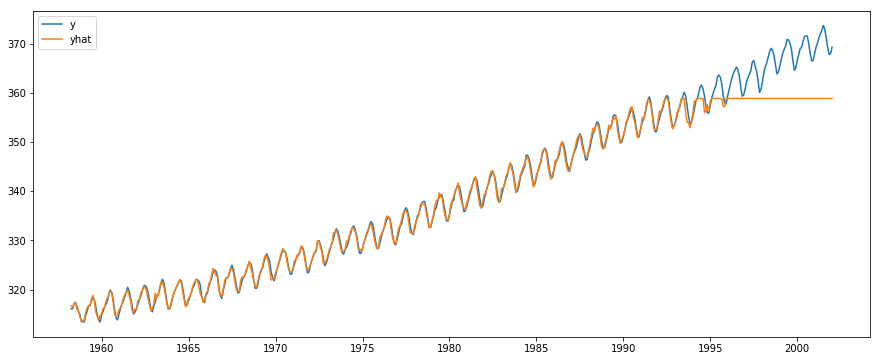

In [112]:
X = df[['x']]
y = df['y']
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
yhat = model.predict(X)
plot_forecast(y,yhat)

In [113]:
X_diff = df[['x']].diff().fillna(method='bfill')
y_diff = df['y'].diff().fillna(method='bfill')

Training R-squared: 0.826000
Test R-squared: 0.420000
Out of Bag Score: 0.343000


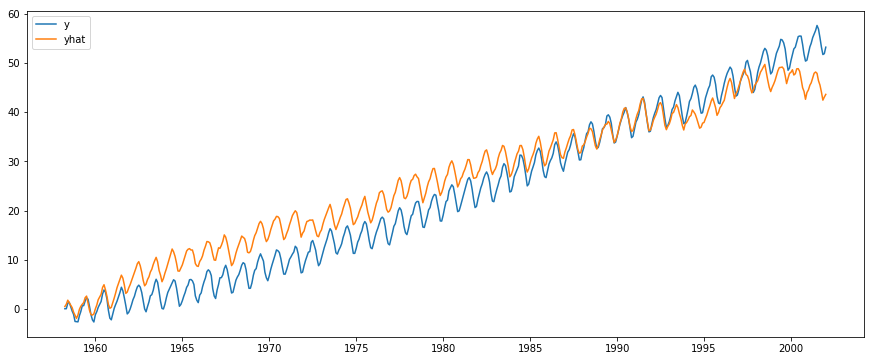

In [115]:
X = X_diff.copy()
y = y_diff
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
yhat = model.predict(X)
plot_forecast(y.cumsum(),yhat.cumsum())

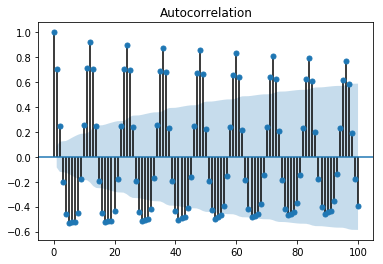

In [89]:
plot_acf(X_diff.x,lags=100)
plt.show()

Training R-squared: 0.996000
Test R-squared: 0.978000
Out of Bag Score: 0.968000


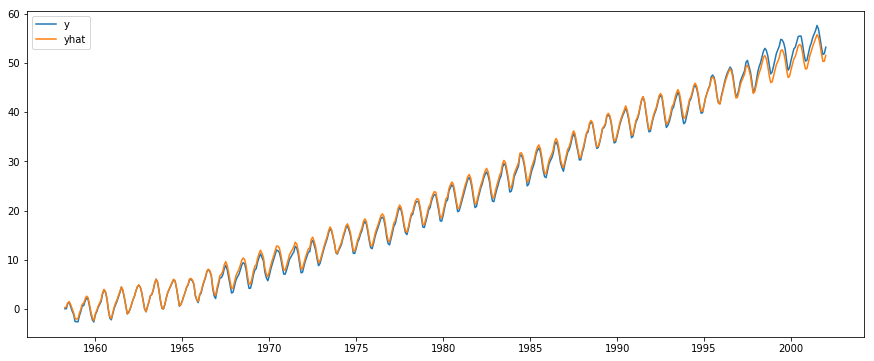

In [116]:
X = get_lag_features(X_diff.copy(),'x',20)
y = y_diff
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
yhat = model.predict(X)
plot_forecast(y.cumsum(),yhat.cumsum())

Training R-squared: 0.992000
Test R-squared: 0.932000


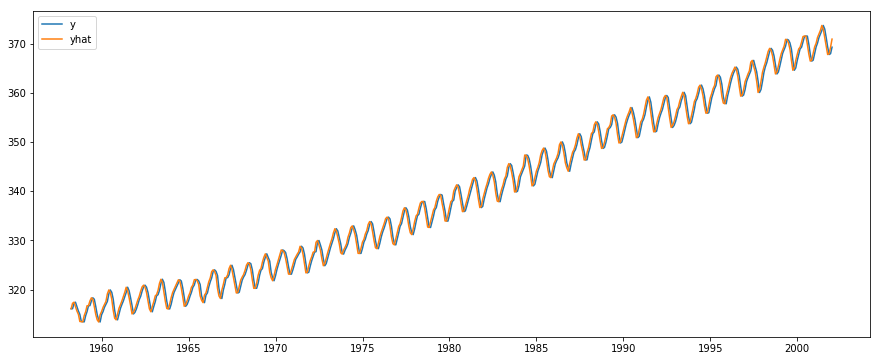

In [118]:
X = df[['x']]
y = df['y']
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

get_scores(None,X_train,y_train,X_test,y_test)
yhat = X.x
plot_forecast(y,yhat)

## Streaming Prediction

In [56]:
warnings.filterwarnings('ignore')
x,y = make_forecasting_frame(df.x, kind="co2", max_timeshift=20, rolling_direction=1)
x.head()

,time,value,id,kind
9785,1958-03-31,316.271429,1958-04-30,co2
9261,1958-03-31,316.271429,1958-05-31,co2
9786,1958-04-30,317.143333,1958-05-31,co2
8738,1958-03-31,316.271429,1958-06-30,co2
9262,1958-04-30,317.143333,1958-06-30,co2


In [52]:
warnings.filterwarnings('ignore')
X = extract_features(x, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                    show_warnings=False, disable_progressbar=True)
X = X.loc[:,X.apply(pd.Series.nunique) != 1]

In [53]:
model = AdaBoostRegressor()

yhat = np.zeros(len(y))
yhat[0] = y.iloc[0]

for i in tqdm(range(1,len(y))):
    X_prevs = X.iloc[:i]
    y_prevs = y[:i]
    Xi = X.iloc[i,:].values.reshape(1,-1)
    model.fit(X_prevs,y_prevs)
    yhat[i] = model.predict(Xi)
    
yhat = pd.Series(data=yhat,index=y.index)

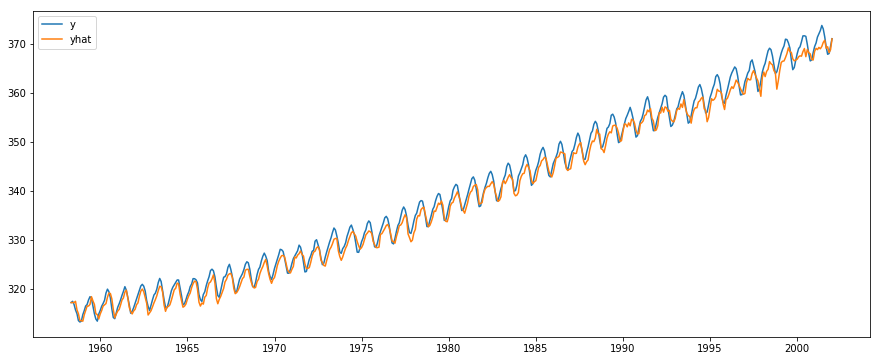

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="y")
plt.plot(yhat, label="yhat")
plt.legend()
plt.show()